In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')

### Overview

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  int64  
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  int64  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

The dataset has 17 predictors, among which there are 4 numerical variables: `BMI`, `PhysicalHealth`, `MentalHealth`, and `SleepTime`.

In [8]:
# take a look at the non-numerical variables
df.describe(include=object)

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
count,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795
unique,2,2,2,2,2,2,6,4,2,2,2,2
top,No,No,No,No,No,Female,White,No,Yes,No,No,No
freq,292422,187887,298018,307726,275385,167805,245212,269653,247957,276923,308016,289976


### Convert `Age` and `GenHealth` to numerical

In [3]:
# convert into ordinal
agecategories = list(df.AgeCategory.unique())
ageMidpoints = [57, 90, 67, 77, 42, 72, 62, 52, 47, 21, 37, 32, 27]
df.AgeCategory.replace(agecategories, ageMidpoints, inplace = True)

healthcategories = list(df.GenHealth.unique())
healthlevels = [4, 2, 3, 1, 5]
df.GenHealth.replace(healthcategories, healthlevels, inplace = True)

### PCA on the numerical predictors

Since we only have 6 numerical predictors to begin with, we don't really need to consider dimensionality reduction with PCA. Let's just give it a try.

In [10]:
# isolate the numerical predictors
X = df.iloc[:, [1, 5, 6, 9, 13, 14]]
# standardize the variables, which are on different scales
X_scale = preprocessing.scale(X)
pca = PCA(n_components=6)
pca.fit(X)

PCA(n_components=6)

Text(0, 0.5, 'Variance Explained')

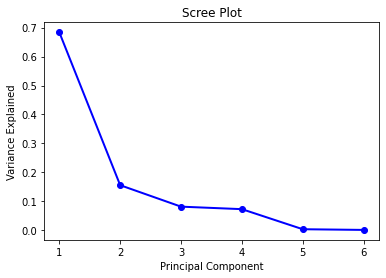

In [11]:
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

Let's keep the first 2 PCs.

In [12]:
# projected data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca

array([[ -0.05593874,  15.90986637],
       [ 34.89985831,  -5.71538746],
       [ 10.75397541,  29.69469507],
       ...,
       [ -7.93765986,  -5.74593145],
       [-27.84630944,  -4.90490404],
       [ 34.78935363,  -1.80341781]])

In [13]:
X_pca = pd.concat([pd.DataFrame(X_pca, columns=['PC1', 'PC2']), df.HeartDisease], axis=1)

In [ ]:
sns.scatterplot(data=X_pca, x='PC1', y='PC2', hue='HeartDisease')

The data points are not well-separated in this reduced dimensional space, so we will just use the original 6 predictors.

### Relationship between predictors and response

#### Numericals

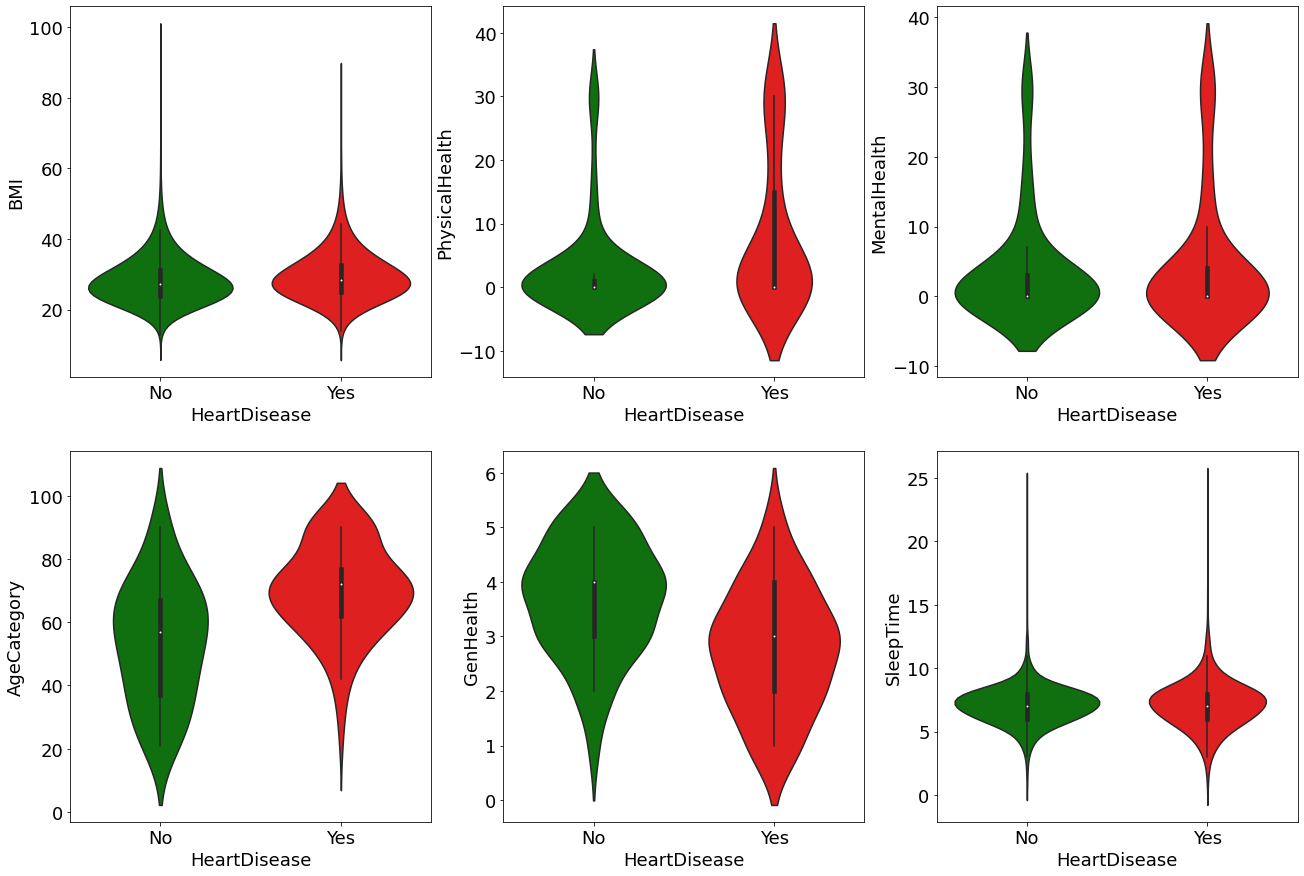

In [6]:
plt.rcParams.update({'font.size': 18})
cols = ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory', 'GenHealth', 'SleepTime']
fig, axes = plt.subplots(2, 3, figsize=(22, 15))
axes = axes.flatten()
iax = 0
for col in cols:
  ax = axes[iax]
  sns.violinplot(x='HeartDisease', y=col, bw = 0.5,
              palette=['green', 'red'],
              data=df, ax=ax)
  iax += 1
plt.savefig('eda_numericals.png')

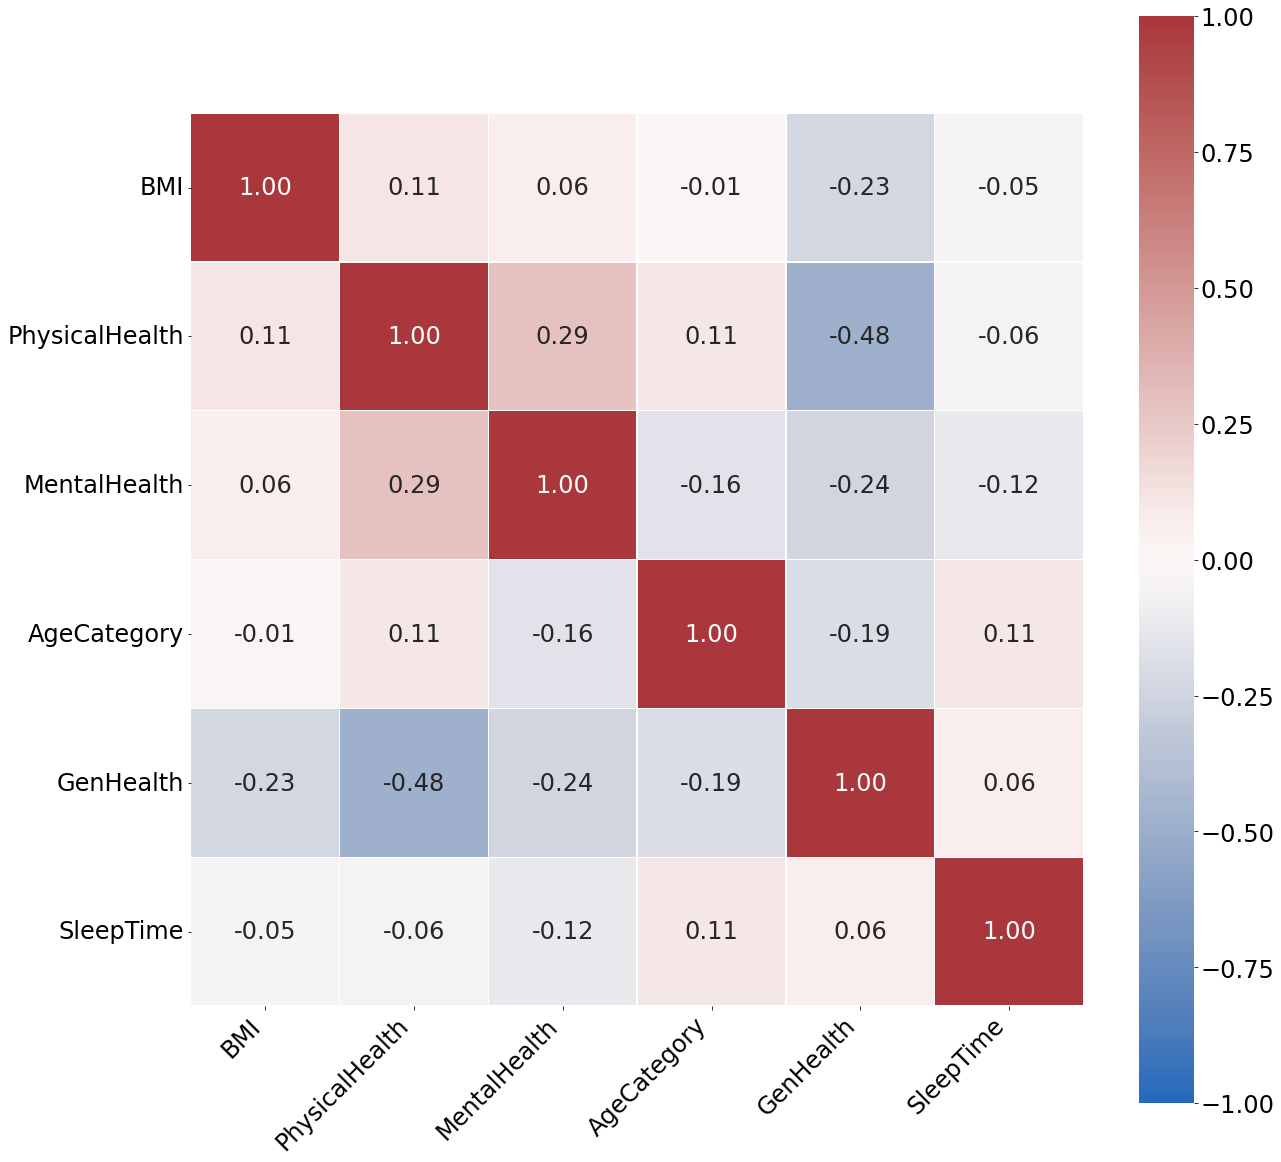

In [7]:
df_num = df.loc[:, ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory', 'GenHealth', 'SleepTime']]
cm = df_num.corr()
cols = cm.index
#sns.set(font_scale=1)
plt.rcParams.update({'font.size': 24})
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, cmap='vlag', center=0,
                 vmin=-1,
                 fmt='.2f', linewidths=0.3, #annot_kws={'size': 8}, 
                 yticklabels=cols.values, xticklabels=cols.values)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45, horizontalalignment='right',
                   fontweight='light')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, horizontalalignment='right',
                   fontweight='light')
plt.savefig('corr_numericals.png')

#### Categoricals

In [ ]:
df = df.set_index('GenHealth').loc[['Poor', 'Fair', 'Good', 'Very good', 'Excellent']].reset_index()
df = df.set_index('AgeCategory').loc[['18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                                      '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']].reset_index()
df = df.set_index('HeartDisease').loc[['No', 'Yes']].reset_index()

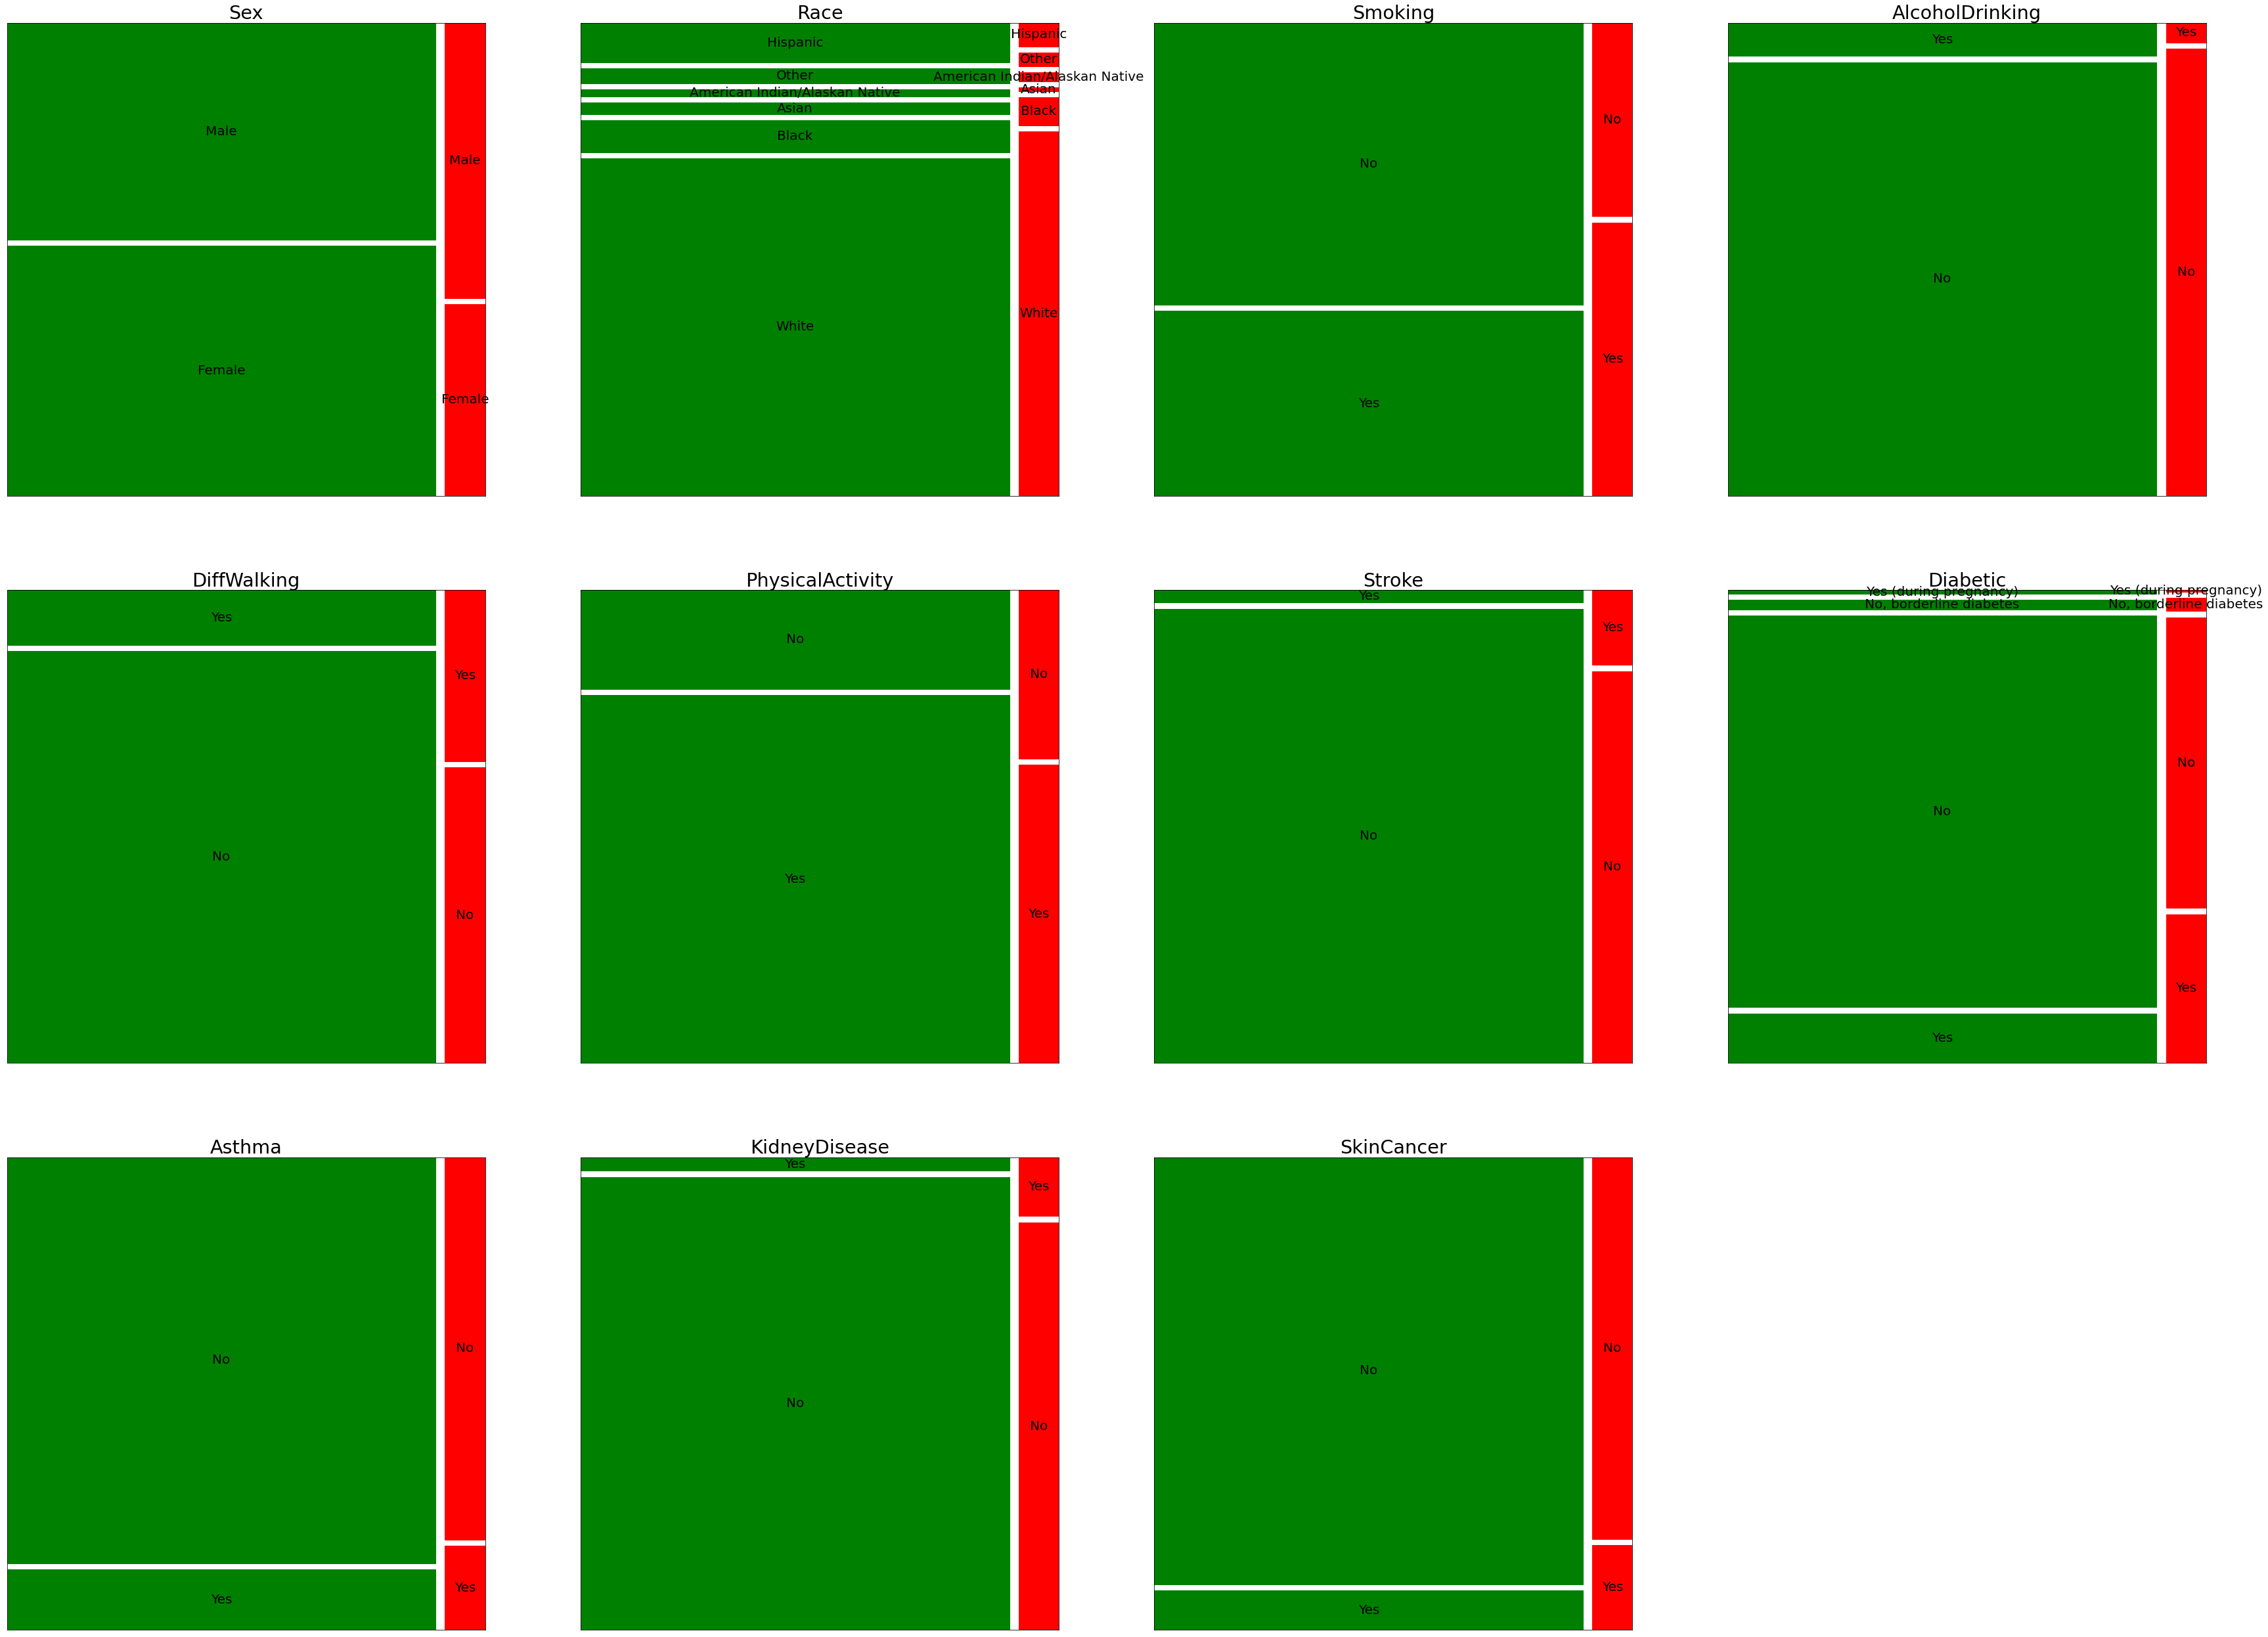

In [11]:
plt.rcParams.update({'font.size': 24})
cols = ['Sex', 'Race', 'Smoking', 'AlcoholDrinking', 'DiffWalking', 'PhysicalActivity',
        'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
props = lambda key: {'color': 'red' if  key[0]=='Yes' else 'green'}

fig, axes = plt.subplots(3, 4, figsize=(60, 45))
axes = axes.flatten()
iax = 0
for col in cols:
  labelizer = {}
  for x in ['No', 'Yes']:
      for y in df[col].unique():
          labelizer[(x, y)] = y
  ax = axes[iax]
  mosaic(df, ['HeartDisease', col], ax=ax,
         axes_label=False, gap = 0.02, title=col, properties=props,
         labelizer=lambda k: labelizer[k])
  iax += 1
axes[iax].set_visible(False)
plt.savefig('eda_categoricals.png')

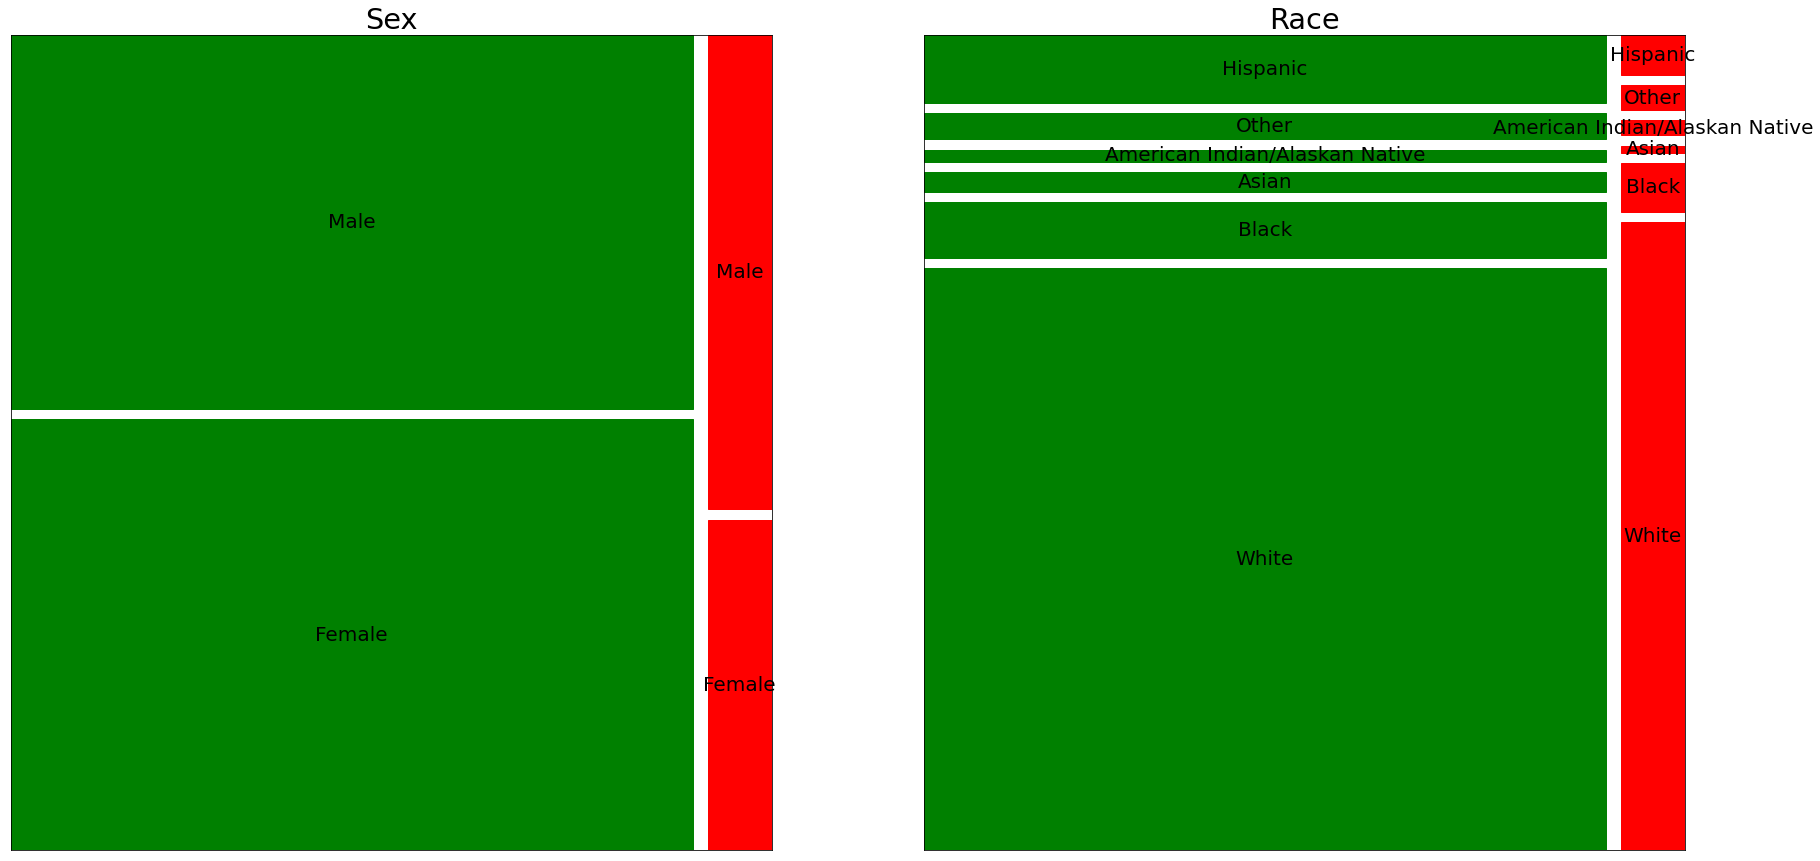

In [18]:
plt.rcParams.update({'font.size': 24})
cols = ['Sex', 'Race']
props = lambda key: {'color': 'red' if  key[0]=='Yes' else 'green'}

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes = axes.flatten()
iax = 0
for col in cols:
  labelizer = {}
  for x in ['No', 'Yes']:
      for y in df[col].unique():
          labelizer[(x, y)] = y
  ax = axes[iax]
  mosaic(df, ['HeartDisease', col], ax=ax,
         axes_label=False, gap = 0.02, title=col, properties=props,
         labelizer=lambda k: labelizer[k])
  iax += 1
#plt.savefig('eda_categoricals.pdf')
#plt.savefig('eda_categoricals.png')

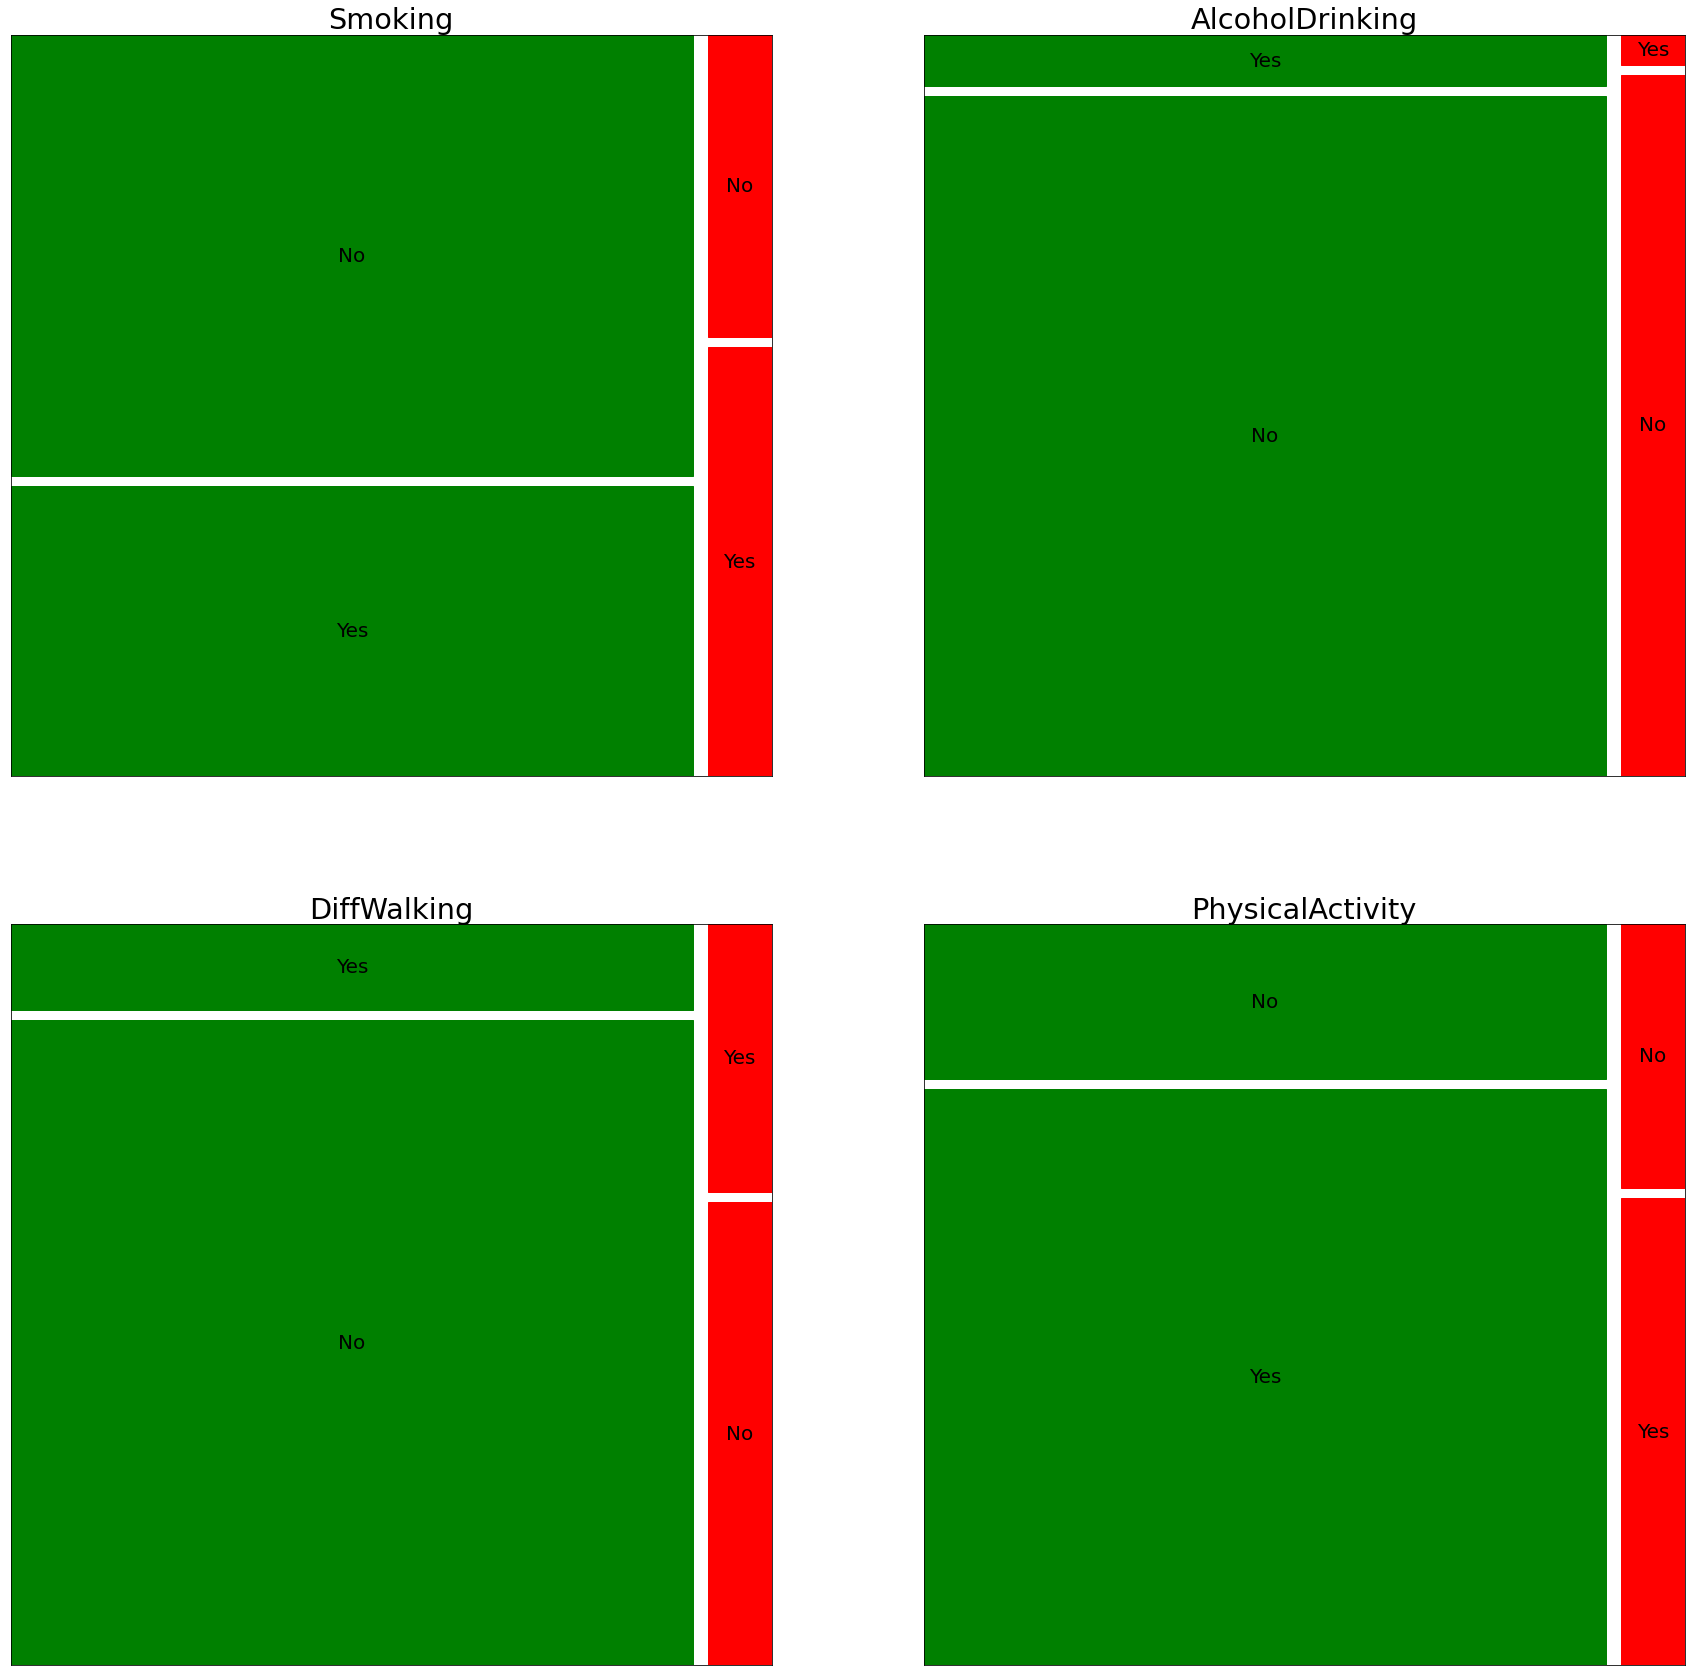

In [ ]:
plt.rcParams.update({'font.size': 24})
cols = ['Smoking', 'AlcoholDrinking', 'DiffWalking', 'PhysicalActivity']
props = lambda key: {'color': 'red' if  key[0]=='Yes' else 'green'}

fig, axes = plt.subplots(2, 2, figsize=(30, 30))
axes = axes.flatten()
iax = 0
for col in cols:
  labelizer = {}
  for x in ['No', 'Yes']:
      for y in df[col].unique():
          labelizer[(x, y)] = y
  ax = axes[iax]
  mosaic(df, ['HeartDisease', col], ax=ax,
         axes_label=False, gap = 0.02, title=col, properties=props,
         labelizer=lambda k: labelizer[k])
  iax += 1

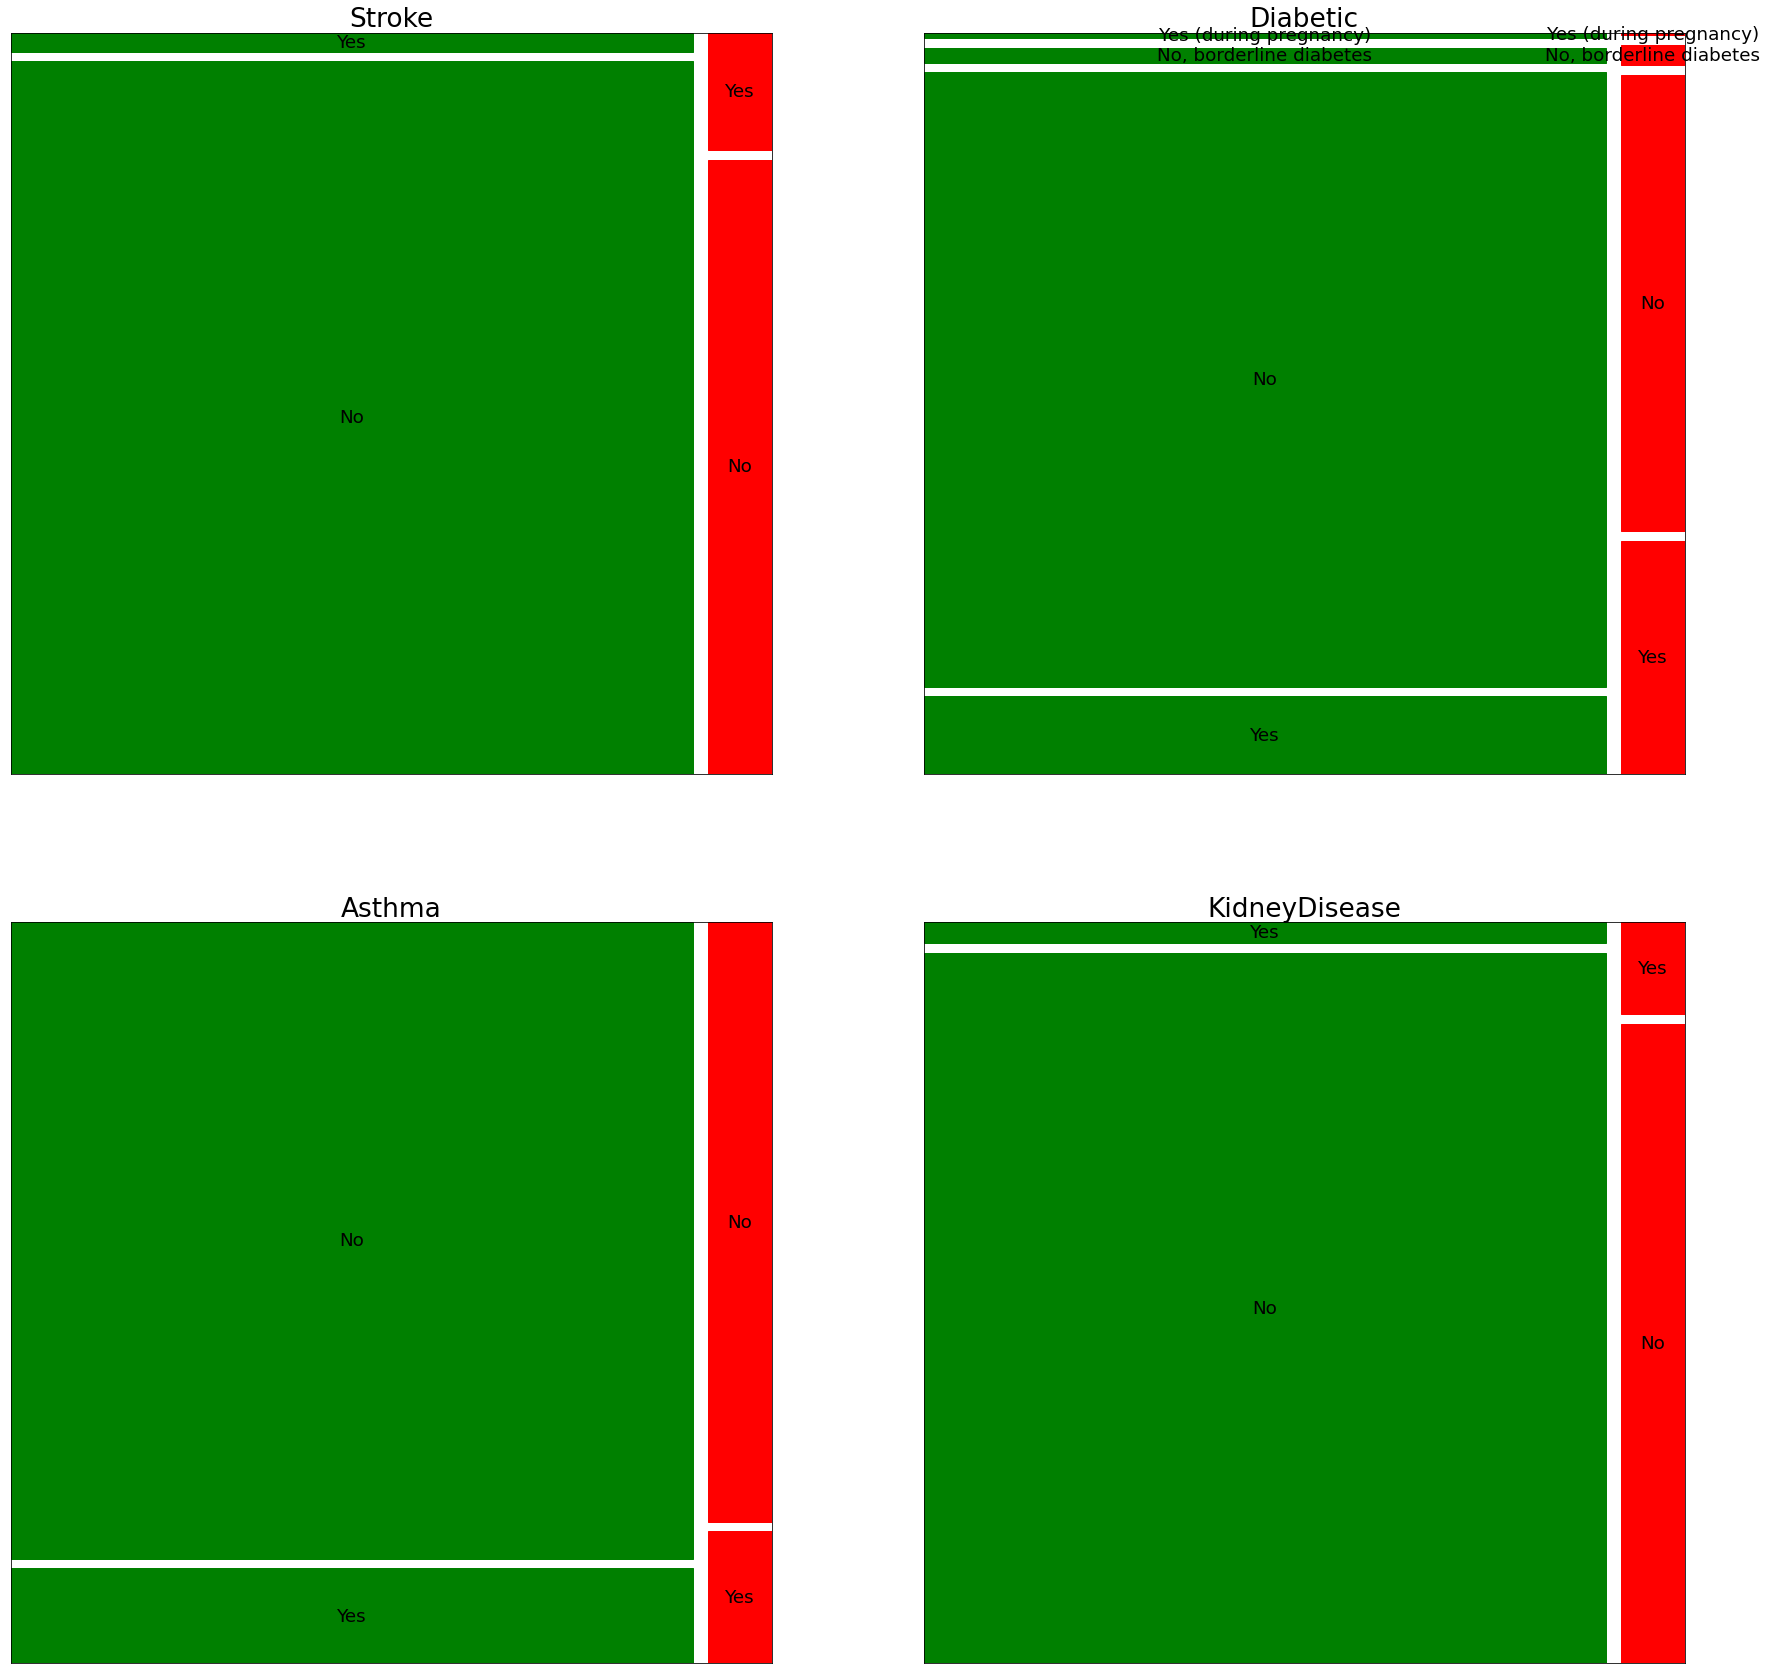

In [ ]:
plt.rcParams.update({'font.size': 22})
cols = ['Stroke', 'Diabetic', 'Asthma', 'KidneyDisease']
props = lambda key: {'color': 'red' if  key[0]=='Yes' else 'green'}

fig, axes = plt.subplots(2, 2, figsize=(30, 30))
axes = axes.flatten()
iax = 0
for col in cols:
  labelizer = {}
  for x in ['No', 'Yes']:
      for y in df[col].unique():
          labelizer[(x, y)] = y
  ax = axes[iax]
  mosaic(df, ['HeartDisease', col], ax=ax,
         axes_label=False, gap = 0.02, title=col, properties=props,
         labelizer=lambda k: labelizer[k])
  iax += 1